In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
from IPython.display import display

# For data preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# For model training and evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Classification algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Temporal algorithms
from hmmlearn import hmm
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier

# For sequence preparation
from collections import defaultdict

# Import our custom cleaning module
import cleaning

# Set random seed for reproducibility
np.random.seed(42)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Create plots directory if it doesn't exist
if not os.path.exists("./plots"):
    os.makedirs("./plots")

In [4]:
def load_and_prepare_data(file_path="./Data/dataset_mood_smartphone.csv"):
    """
    Load and prepare the data for analysis and modeling.
    """
    print("Loading and preparing data...")

    # Load the data using our existing cleaning module
    raw_data, users = cleaning.loadData(file_path)

    # Resample to daily data
    daily_data = cleaning.resample_daily(raw_data, users)

    # Prune to keep only the longest continuous period with mood data
    pruned_daily = cleaning.pruneDays(daily_data, users, method="longest", baseFrame=raw_data)

    print(f"Data loaded successfully. Found {len(users)} users.")

    return pruned_daily, users

# Load the data
data, users = load_and_prepare_data()

Loading and preparing data...
Data loaded successfully. Found 27 users.


In [5]:
def create_sliding_window_features(data, users, window_size=3):
    """
    Create features using a sliding window of past days to predict the next day's mood.

    Args:
        data: The dataset (multi-index DataFrame with user and time)
        users: List of user IDs
        window_size: Number of past days to use for prediction (default: 3)

    Returns:
        X: Feature matrix where each row contains features from window_size days
        y: Target vector (next day's mood class)
        user_ids: Array of user IDs corresponding to each sample
        timestamps: Array of timestamps for the target day
    """
    print(f"\n--- Creating {window_size}-Day Sliding Window Features ---")

    # Create a copy of the data
    processed_data = data.copy()

    # Fill missing values with median for each user
    for user in users:
        for col in processed_data.columns:
            if processed_data.loc[user][col].isna().any():
                user_median = processed_data.loc[user][col].median()
                if pd.isna(user_median):
                    user_median = 0
                processed_data.loc[user, col] = processed_data.loc[user][col].fillna(user_median)

    # Create features and target dataframes
    X_data = []
    y_data = []
    user_ids = []
    timestamps = []

    # Get feature names (excluding 'mood')
    feature_names = [col for col in processed_data.columns if col != 'mood']
    num_features = len(feature_names)

    for user in users:
        user_data = processed_data.loc[user]

        # Skip users with insufficient data
        if len(user_data) < window_size + 1:
            continue

        # For each possible window in the user's data
        for i in range(len(user_data) - window_size):
            # Get window of past days
            window_data = user_data.iloc[i:i+window_size]

            # Create a flat feature vector containing all features from all days in the window
            window_features = []
            for day in range(window_size):
                # Extract features for this day (excluding mood)
                day_features = window_data.iloc[day][feature_names].values
                window_features.extend(day_features)

            # Next day's mood (target)
            next_day_mood = user_data.iloc[i+window_size]['mood']
            next_day_timestamp = user_data.index[i+window_size]

            # Convert to 4 classes based on quartiles
            user_mood_quartiles = user_data['mood'].quantile([0.25, 0.5, 0.75]).values

            if next_day_mood < user_mood_quartiles[0]:
                mood_class = 0  # Very low mood
            elif next_day_mood < user_mood_quartiles[1]:
                mood_class = 1  # Low mood
            elif next_day_mood < user_mood_quartiles[2]:
                mood_class = 2  # Good mood
            else:
                mood_class = 3  # Very good mood

            # Only add if there are no NaN values in the features
            if not np.isnan(window_features).any():
                X_data.append(window_features)
                y_data.append(mood_class)
                user_ids.append(user)
                timestamps.append(next_day_timestamp)

    # Convert to numpy arrays
    X = np.array(X_data)
    y = np.array(y_data)
    user_ids = np.array(user_ids)
    timestamps = np.array(timestamps)

    # Create expanded feature names to include day information
    expanded_feature_names = []
    for day in range(window_size):
        day_features = [f"day-{window_size-day}_{feat}" for feat in feature_names]
        expanded_feature_names.extend(day_features)

    print(f"Sliding window features created. X shape: {X.shape}, y shape: {y.shape}")
    print(f"Each sample contains {window_size} days of data ({num_features} features per day)")
    print(f"Class distribution: {np.bincount(y)}")

    # Visualize class distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x=y)
    plt.title(f'Distribution of Mood Classes ({window_size}-Day Window)')
    plt.xlabel('Mood Class')
    plt.xticks([0, 1, 2, 3], ['Very Low', 'Low', 'Good', 'Very Good'])
    plt.ylabel('Count')
    plt.savefig(f"./plots/class_distribution_{window_size}day_window.png")
    plt.show()

    return X, y, expanded_feature_names, user_ids, timestamps


--- Creating 3-Day Sliding Window Features ---
Sliding window features created. X shape: (704, 54), y shape: (704,)
Each sample contains 3 days of data (18 features per day)
Class distribution: [152 154 176 222]


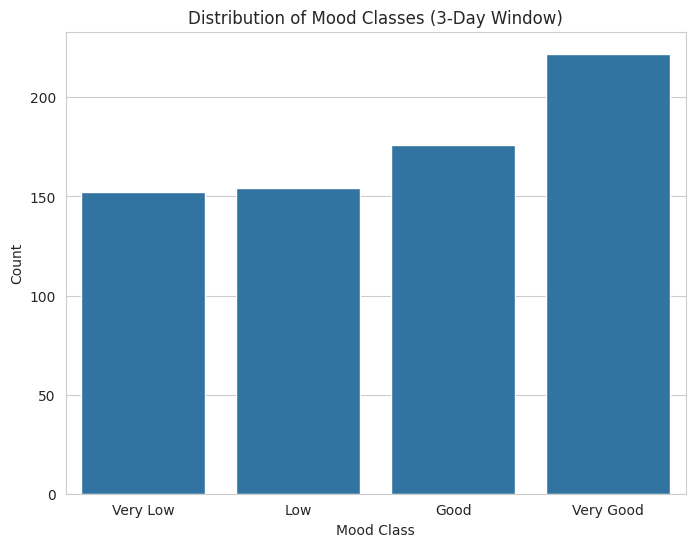


Comparison:
Single-day approach: 54 features per sample
3-day window approach: 54 features per sample


In [6]:
# Create features using a 3-day sliding window
window_size = 3
X_window, y_window, feature_names_window, user_ids_window, timestamps_window = create_sliding_window_features(
    data, users, window_size=window_size
)

# Compare with single-day features
print("\nComparison:")
print(f"Single-day approach: {len(feature_names_window)} features per sample")
print(f"{window_size}-day window approach: {len(feature_names_window)} features per sample")

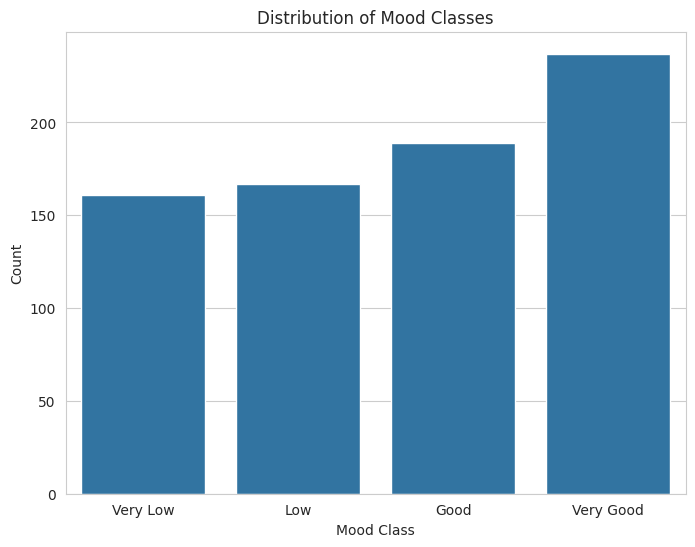

In [7]:
def prepare_features_and_target(data, users):
    # Create a copy of the data
    processed_data = data.copy()

    # Fill missing values with median for each user
    for user in users:
        for col in processed_data.columns:
            if processed_data.loc[user][col].isna().any():
                user_median = processed_data.loc[user][col].median()
                if pd.isna(user_median):
                    user_median = 0
                processed_data.loc[user, col] = processed_data.loc[user][col].fillna(user_median)

    # Create features and target dataframes
    X_data = []
    y_data = []
    user_ids = []  # Store user IDs for temporal models
    timestamps = []  # Store timestamps for temporal models

    for user in users:
        user_data = processed_data.loc[user]

        # Skip users with less than 2 days of data
        if len(user_data) < 2:
            continue

        # For each day, use current day's data to predict next day's mood
        for i in range(len(user_data) - 1):
            # Current day's features
            features = user_data.iloc[i].drop('mood').values

            # Next day's mood (target)
            next_day_mood = user_data.iloc[i+1]['mood']

            # Convert to 4 classes based on quartiles
            # Class 0: Very low mood (0-25th percentile)
            # Class 1: Low mood (25-50th percentile)
            # Class 2: Good mood (50-75th percentile)
            # Class 3: Very good mood (75-100th percentile)
            user_mood_quartiles = user_data['mood'].quantile([0.25, 0.5, 0.75]).values

            if next_day_mood < user_mood_quartiles[0]:
                mood_class = 0  # Very low mood
            elif next_day_mood < user_mood_quartiles[1]:
                mood_class = 1  # Low mood
            elif next_day_mood < user_mood_quartiles[2]:
                mood_class = 2  # Good mood
            else:
                mood_class = 3  # Very good mood

            # Only add if there are no NaN values in the features
            if not np.isnan(features).any():
                X_data.append(features)
                y_data.append(mood_class)
                user_ids.append(user)
                timestamps.append(user_data.index[i+1])  # Next day's timestamp

    # Convert to numpy arrays
    X = np.array(X_data)
    y = np.array(y_data)
    user_ids = np.array(user_ids)
    timestamps = np.array(timestamps)

    # Get feature names (excluding 'mood')
    feature_names = [col for col in processed_data.columns if col != 'mood']

    # Visualize class distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x=y)
    plt.title('Distribution of Mood Classes')
    plt.xlabel('Mood Class')
    plt.xticks([0, 1, 2, 3], ['Very Low', 'Low', 'Good', 'Very Good'])
    plt.ylabel('Count')
    plt.savefig("./plots/class_distribution.png")
    plt.show()

    return X, y, feature_names, user_ids, timestamps

# Prepare features and target
X, y, feature_names, user_ids, timestamps = prepare_features_and_target(data, users)

In [8]:
def train_and_evaluate_models(X, y, feature_names, user_ids=None, timestamps=None, visual=True):
    # Check for any remaining NaN values
    if np.isnan(X).any():
        print("WARNING: NaN values detected in features. Removing rows with NaN values.")
        # Find rows without NaN values
        mask = ~np.isnan(X).any(axis=1)
        X = X[mask]
        y = y[mask]
        if user_ids is not None:
            user_ids = user_ids[mask]
        if timestamps is not None:
            timestamps = timestamps[mask]
        print(f"After removing NaN values: X shape: {X.shape}, y shape: {y.shape}")

    # Split data into training and testing sets (80% train, 20% test)
    if user_ids is not None and timestamps is not None:
        # Use time-based split for temporal data
        # Sort by timestamp
        sorted_indices = np.argsort(timestamps)
        X = X[sorted_indices]
        y = y[sorted_indices]
        user_ids = user_ids[sorted_indices]
        timestamps = timestamps[sorted_indices]

        # Use the last 20% as test set
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        user_ids_train, user_ids_test = user_ids[:split_idx], user_ids[split_idx:]
        timestamps_train, timestamps_test = timestamps[:split_idx], timestamps[split_idx:]
    else:
        # Regular stratified split for non-temporal models
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define models to evaluate
    models = {
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'KNN': KNeighborsClassifier(),
        'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr', max_iter=1000)
    }

    # Dictionary to store results
    results = {}

    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")

        try:
            # Train the model
            model.fit(X_train_scaled, y_train)

            # Make predictions
            y_pred = model.predict(X_test_scaled)

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            # Use macro averaging for multi-class classification
            precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
            recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

            if visual:
                # Print results
                print(f"{name} Results:")
                print(f"Accuracy: {accuracy:.4f}")
                print(f"Precision: {precision:.4f}")
                print(f"Recall: {recall:.4f}")
                print(f"F1 Score: {f1:.4f}")

                # Print classification report
                print("\nClassification Report:")
                print(classification_report(y_test, y_pred, zero_division=0))

                # Print confusion matrix
                print("\nConfusion Matrix:")
                cm = confusion_matrix(y_test, y_pred)
                print(cm)

                # Plot confusion matrix
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                            xticklabels=['Very Low', 'Low', 'Good', 'Very Good'],
                            yticklabels=['Very Low', 'Low', 'Good', 'Very Good'])
                plt.xlabel('Predicted')
                plt.ylabel('Actual')
                plt.title(f'Confusion Matrix - {name}')
                plt.tight_layout()
                plt.savefig(f"./plots/confusion_matrix_{name.replace(' ', '_').lower()}.png")
                plt.show()

                # Store results
                results[name] = {
                    'model': model,
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'confusion_matrix': cm,
                    'y_pred': y_pred
                }

                # Feature importance for tree-based models
                if name in ['Decision Tree', 'Random Forest']:
                    importances = model.feature_importances_
                    indices = np.argsort(importances)[::-1]

                    # Plot feature importance
                    plt.figure(figsize=(12, 8))
                    plt.title(f'Feature Importance - {name}')
                    plt.bar(range(min(10, X.shape[1])), importances[indices[:10]], align='center')
                    plt.xticks(range(min(10, X.shape[1])), [feature_names[i] for i in indices[:10]], rotation=90)
                    plt.tight_layout()
                    plt.savefig(f"./plots/feature_importance_{name.replace(' ', '_').lower()}.png")
                    plt.show()

                    # Print top 10 features
                    print("\nTop 10 Features:")
                    for i in range(min(10, X.shape[1])):
                        print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            print(f"Skipping {name} model.")

    return results, X_train_scaled, y_train, X_test_scaled, y_test, user_ids_train, user_ids_test

In [9]:
# Train and evaluate models
results, X_train_window_scaled, y_train_window, X_test_window_scaled, y_test_window, user_ids_train_window, user_ids_test_window = train_and_evaluate_models(
    X_window, y_window, feature_names_window, user_ids_window, timestamps_window, visual=False
)


Training Decision Tree...

Training Random Forest...

Training SVM...

Training KNN...

Training Logistic Regression...


In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_macro',  # You can also try 'accuracy' or 'recall_macro'
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit to training data
grid_search.fit(X_train_window_scaled, y_train_window)

# Best model
best_rf = grid_search.best_estimator_
print("\nBest Hyperparameters:")
print(grid_search.best_params_)

# Evaluate on the test set
y_pred_rf = best_rf.predict(X_test_window_scaled)

# Print final evaluation
print("\nFinal Evaluation on Test Set:")
print(classification_report(y_test_window, y_pred_rf, zero_division=0))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END max_depth=N

In [12]:
# Define a scaling factor for text sizes
factor = 1.5  # Increase or decrease this to scale all font sizes

# Create a pivot table for heatmap
pivot_table = cv_results.pivot_table(
    index='param_n_estimators',
    columns='param_max_depth',
    values='mean_test_score'
)

# Plot heatmap with scaled text
plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".4f",
    cmap='viridis',
    annot_kws={"size": 8 * factor}
)

plt.title('F1 Macro Score by n_estimators and max_depth', fontsize=12 * factor)
plt.xlabel('max_depth', fontsize=10 * factor)
plt.ylabel('n_estimators', fontsize=10 * factor)
plt.xticks(fontsize=8 * factor)
plt.yticks(fontsize=8 * factor)
plt.tight_layout()

# Save to PDF
plt.savefig("RFhyp.pdf", format='pdf')
plt.show()


NameError: name 'cv_results' is not defined

In [ ]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

# Assuming you already have X_train, y_train, X_test, y_test
def tune_hmm_n_components(X_train, y_train, X_test, y_test, n_range, factor=1.0):
    scores = []
    for n in n_range:
        try:
            model = hmm.GaussianHMM(n_components=n, covariance_type='diag', n_iter=100, random_state=42)
            model.fit(X_train)

            # Predict hidden states
            hidden_states = model.predict(X_test)

            # Map hidden states to classes via majority vote on training set
            state_class_map = {}
            train_states = model.predict(X_train)
            for state in np.unique(train_states):
                state_indices = np.where(train_states == state)[0]
                if len(state_indices) > 0:
                    majority_class = np.bincount(y_train[state_indices]).argmax()
                    state_class_map[state] = majority_class

            y_pred = np.array([state_class_map.get(state, 0) for state in hidden_states])
            f1 = f1_score(y_test, y_pred, average='macro')
            scores.append((n, f1))
            print(f'n_components={n}, F1 macro score={f1:.4f}')
        except Exception as e:
            print(f"Error with n_components={n}: {e}")
            scores.append((n, np.nan))

    # Convert to array for plotting
    scores = np.array(scores)

    # Plot results
    plt.figure(figsize=(8 * factor, 5 * factor))
    sns.lineplot(x=scores[:, 0], y=scores[:, 1], marker='o')
    plt.title('F1 Macro Score vs. n_components', fontsize=14 * factor)
    plt.xlabel('Number of Hidden States (n_components)', fontsize=12 * factor)
    plt.ylabel('F1 Macro Score', fontsize=12 * factor)
    plt.xticks(fontsize=10 * factor)
    plt.yticks(fontsize=10 * factor)
    plt.tight_layout()
    plt.savefig('HMMhyp.pdf')
    plt.show()

    return scores


n_components=2, F1 macro score=0.1126


Model is not converging.  Current: -24689.291089307004 is not greater than -24689.26910682604. Delta is -0.021982480964652495


n_components=3, F1 macro score=0.1126


Model is not converging.  Current: -23380.810992835904 is not greater than -23380.394396273023. Delta is -0.4165965628817503


n_components=4, F1 macro score=0.1505
n_components=5, F1 macro score=0.1918
n_components=6, F1 macro score=0.1710


Model is not converging.  Current: -17666.977482026832 is not greater than -17666.957650052223. Delta is -0.019831974608678138


n_components=7, F1 macro score=0.1430
n_components=8, F1 macro score=0.1484


Model is not converging.  Current: -14785.758359244022 is not greater than -14785.683483824687. Delta is -0.07487541933551256


n_components=9, F1 macro score=0.1705
n_components=10, F1 macro score=0.1854
n_components=11, F1 macro score=0.1430
n_components=12, F1 macro score=0.1799


Model is not converging.  Current: -15108.935633899018 is not greater than -15108.912303659206. Delta is -0.02333023981191218


n_components=13, F1 macro score=0.1516
n_components=14, F1 macro score=0.1351


Model is not converging.  Current: -13635.382408319716 is not greater than -13635.344911579863. Delta is -0.037496739852940664


n_components=15, F1 macro score=0.1587
n_components=16, F1 macro score=0.1652


Model is not converging.  Current: -12141.818896001627 is not greater than -12141.80397804165. Delta is -0.014917959977537976


n_components=17, F1 macro score=0.2515
n_components=18, F1 macro score=0.1317


Model is not converging.  Current: -12421.009483953845 is not greater than -12420.96024197671. Delta is -0.049241977134443005


n_components=19, F1 macro score=0.1541
n_components=20, F1 macro score=0.2180


Model is not converging.  Current: -11418.604524777114 is not greater than -11418.603849573305. Delta is -0.0006752038098056801


n_components=21, F1 macro score=0.1531
n_components=22, F1 macro score=0.2387
n_components=23, F1 macro score=0.1913
n_components=24, F1 macro score=0.1608


Model is not converging.  Current: -9815.781361318346 is not greater than -9815.257475475271. Delta is -0.5238858430748223


n_components=25, F1 macro score=0.2098
n_components=26, F1 macro score=0.1751


Model is not converging.  Current: -9171.530856406505 is not greater than -9171.50233443367. Delta is -0.028521972835733322


n_components=27, F1 macro score=0.2438


Model is not converging.  Current: -9092.63723286185 is not greater than -9092.414424999713. Delta is -0.2228078621374152


n_components=28, F1 macro score=0.1866
n_components=29, F1 macro score=0.1839


Model is not converging.  Current: -8936.637242497152 is not greater than -8936.636088878602. Delta is -0.0011536185502336593


n_components=30, F1 macro score=0.2423


Model is not converging.  Current: -7862.045528861178 is not greater than -7862.0418164217535. Delta is -0.0037124394248166936


n_components=31, F1 macro score=0.2699


Model is not converging.  Current: -9108.527824868244 is not greater than -9108.447766052097. Delta is -0.08005881614735699


n_components=32, F1 macro score=0.2814


Model is not converging.  Current: -9111.118035833 is not greater than -9111.07110324032. Delta is -0.04693259268060501


n_components=33, F1 macro score=0.2197
n_components=34, F1 macro score=0.2347
n_components=35, F1 macro score=0.2200


Model is not converging.  Current: -8498.303585097656 is not greater than -8498.30300258762. Delta is -0.0005825100361107616


n_components=36, F1 macro score=0.2395
n_components=37, F1 macro score=0.1914
n_components=38, F1 macro score=0.2155


Model is not converging.  Current: -8678.134387186865 is not greater than -8678.11337930685. Delta is -0.021007880015531555


n_components=39, F1 macro score=0.1376


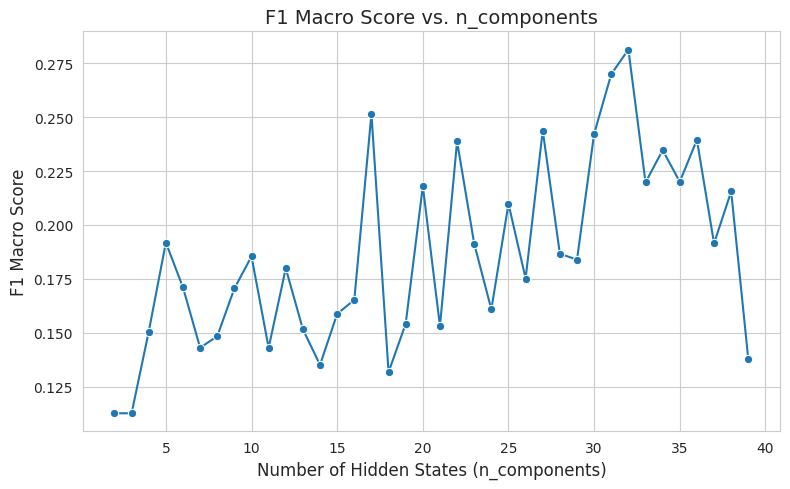

In [ ]:
scores = tune_hmm_n_components(
    X_train_window_scaled,
    y_train_window,
    X_test_window_scaled,
    y_test_window,
    n_range=range(2, 40),
    factor=1.0  # Adjust font size for Overleaf export
)

In [ ]:
from hmmlearn.hmm import GaussianHMM

def train_and_evaluate_models(X, y, feature_names, user_ids=None, timestamps=None, visual=True):
    # Check for any remaining NaN values
    if np.isnan(X).any():
        print("WARNING: NaN values detected in features. Removing rows with NaN values.")
        # Find rows without NaN values
        mask = ~np.isnan(X).any(axis=1)
        X = X[mask]
        y = y[mask]
        if user_ids is not None:
            user_ids = user_ids[mask]
        if timestamps is not None:
            timestamps = timestamps[mask]
        print(f"After removing NaN values: X shape: {X.shape}, y shape: {y.shape}")

    # Split data into training and testing sets (80% train, 20% test)
    if user_ids is not None and timestamps is not None:
        # Use time-based split for temporal data
        # Sort by timestamp
        sorted_indices = np.argsort(timestamps)
        X = X[sorted_indices]
        y = y[sorted_indices]
        user_ids = user_ids[sorted_indices]
        timestamps = timestamps[sorted_indices]

        # Use the last 20% as test set
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        user_ids_train, user_ids_test = user_ids[:split_idx], user_ids[split_idx:]
        timestamps_train, timestamps_test = timestamps[:split_idx], timestamps[split_idx:]
    else:
        # Regular stratified split for non-temporal models
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define models to evaluate (Only Random Forest and HMM)
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=300, max_depth=30, random_state=42),
        'Hidden Markov Model': GaussianHMM(n_components=17, covariance_type="full", n_iter=1000, random_state=42)
    }

    # Dictionary to store results
    results = {}

    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")

        try:
            if name == 'Random Forest':
                # Train Random Forest
                model.fit(X_train_scaled, y_train)

                # Make predictions
                y_pred = model.predict(X_test_scaled)

            elif name == 'Hidden Markov Model':
                # Train HMM - HMM expects data to be in shape (n_samples, n_features), not (n_samples,)
                X_train_hmm = X_train_scaled.reshape(len(X_train_scaled), -1)  # Reshaping for HMM
                X_test_hmm = X_test_scaled.reshape(len(X_test_scaled), -1)

                model.fit(X_train_hmm)

                # Predict using HMM
                y_pred = model.predict(X_test_hmm)

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
            recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

            if visual:
                # Print results
                print(f"{name} Results:")
                print(f"Accuracy: {accuracy:.4f}")
                print(f"Precision: {precision:.4f}")
                print(f"Recall: {recall:.4f}")
                print(f"F1 Score: {f1:.4f}")

                # Print classification report
                print("\nClassification Report:")
                print(classification_report(y_test, y_pred, zero_division=0))

                # Print confusion matrix
                print("\nConfusion Matrix:")
                cm = confusion_matrix(y_test, y_pred)
                print(cm)

                # Plot confusion matrix
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                            xticklabels=['Very Low', 'Low', 'Good', 'Very Good'],
                            yticklabels=['Very Low', 'Low', 'Good', 'Very Good'])
                plt.xlabel('Predicted')
                plt.ylabel('Actual')
                plt.title(f'Confusion Matrix - {name}')
                plt.tight_layout()
                plt.savefig(f"./plots/confusion_matrix_{name.replace(' ', '_').lower()}.pdf")
                plt.show()

                # Store results
                results[name] = {
                    'model': model,
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'confusion_matrix': cm,
                    'y_pred': y_pred
                }

        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            print(f"Skipping {name} model.")

    return results, X_train_scaled, y_train, X_test_scaled, y_test, user_ids_train, user_ids_test


In [ ]:
# Assuming the 'train_and_evaluate_models' function is defined above and is set to only train Random Forest and HMM

# Your dataset (make sure you have X, y, feature_names, user_ids, and timestamps properly defined)
# Replace X_window, y_window, etc., with your actual variables if different
X = X_window  # Your feature matrix
y = y_window  # Your target vector
feature_names = feature_names_window  # Your feature names
user_ids = user_ids_window  # User IDs if applicable
timestamps = timestamps_window  # Timestamps if applicable

# Call the function to train and evaluate models (only Random Forest and HMM)
results, X_train_scaled, y_train, X_test_scaled, y_test, user_ids_train, user_ids_test = train_and_evaluate_models(
    X, y, feature_names, user_ids, timestamps, visual=True
)

# If you want to save confusion matrices as PDFs
for model_name, result in results.items():
    cm = result['confusion_matrix']

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Very Low', 'Low', 'Good', 'Very Good'],
                yticklabels=['Very Low', 'Low', 'Good', 'Very Good'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()

    # Save the confusion matrix as a PDF
    plt.savefig(f"./plots/confusion_matrix_{model_name.replace(' ', '_').lower()}.pdf")
    plt.close()

# At this point, your confusion matrices for both models (Random Forest and HMM) should be saved as PDFs in the "./plots" directory.


NameError: name 'X_window' is not defined


Model Comparison:


,Model,accuracy,precision,recall,f1
0,Random Forest,0.269504,0.226923,0.250529,0.219430
1,Hidden Markov Model,0.269504,0.198814,0.284722,0.232875


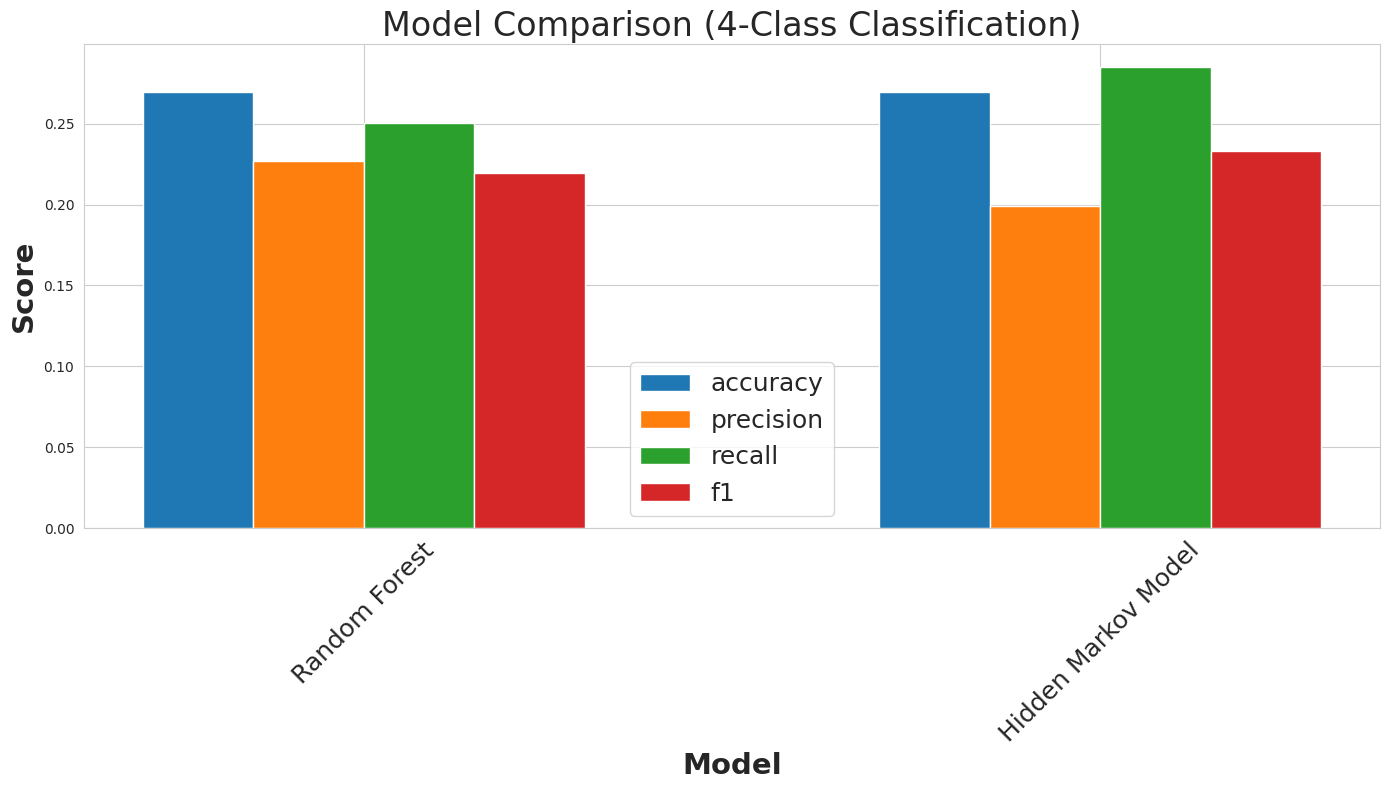


Best Model: Hidden Markov Model
F1 Score: 0.2329

Detailed Class Performance:

Random Forest - Confusion Matrix:


,Pred: Very Low,Pred: Low,Pred: Good,Pred: Very Good
True: Very Low,7,4,4,17
True: Low,9,2,4,17
True: Good,10,3,4,19
True: Very Good,4,4,8,25



Hidden Markov Model - Confusion Matrix:


,Pred: Very Low,Pred: Low,Pred: Good,Pred: Very Good
True: Very Low,8,13,11,0
True: Low,7,16,9,0
True: Good,6,16,14,0
True: Very Good,19,10,12,0


In [ ]:
def compare_models(results, factor=1.2):
    # Only select Random Forest and HMM models from the results
    model_names = ['Random Forest', 'Hidden Markov Model']
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    comparison_data = []
    for name in model_names:
        row = [name]
        for metric in metrics:
            row.append(results[name][metric])
        comparison_data.append(row)

    comparison_df = pd.DataFrame(comparison_data, columns=['Model'] + metrics)

    # Print comparison table
    print("\nModel Comparison:")
    display(comparison_df)

    # Plot comparison
    plt.figure(figsize=(14, 8))

    # Set width of bars
    barWidth = 0.15

    # Set positions of the bars on X axis
    r = np.arange(len(model_names))

    # Create bars
    for i, metric in enumerate(metrics):
        plt.bar(r + i * barWidth, comparison_df[metric], width=barWidth, label=metric)

    # Add labels and title with adjustable font size based on the factor
    plt.xlabel('Model', fontweight='bold', fontsize=14 * factor)
    plt.ylabel('Score', fontweight='bold', fontsize=14 * factor)
    plt.title('Model Comparison (4-Class Classification)', fontsize=16 * factor)
    plt.xticks(r + barWidth * (len(metrics) - 1) / 2, model_names, rotation=45, fontsize=12 * factor)
    plt.legend(fontsize=12 * factor)
    plt.tight_layout()

    # Save the plot as a PDF
    plt.savefig("./plots/model_comparison_RF_HMM.pdf", format='pdf')
    plt.show()

    # Find the best model based on F1 score
    best_model_idx = comparison_df['f1'].idxmax()
    best_model_name = comparison_df.loc[best_model_idx, 'Model']
    best_model = results[best_model_name]['model']

    print(f"\nBest Model: {best_model_name}")
    print(f"F1 Score: {results[best_model_name]['f1']:.4f}")

    # Create a more detailed comparison focusing on per-class performance
    print("\nDetailed Class Performance:")
    for name in model_names:
        print(f"\n{name} - Confusion Matrix:")
        display(pd.DataFrame(
            results[name]['confusion_matrix'],
            columns=['Pred: Very Low', 'Pred: Low', 'Pred: Good', 'Pred: Very Good'],
            index=['True: Very Low', 'True: Low', 'True: Good', 'True: Very Good']
        ))

    return best_model_name, best_model

# Compare Random Forest and Hidden Markov Model
best_model_name, best_model = compare_models(results, factor=1.5)
